# Calibration

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
cal1_path="/home/ema/Uni/LCP/LCPa_Project/180904/Run000263/data_000000.txt"

#best detectors configuration for a given run
calib_config=[0,1]

In [3]:
cal1={}
false_events_counter=0
with open(cal1_path) as cal1_file:
    for line in cal1_file:
        row=line.strip().split()
        key=int(row[0])
        n_hits=int(row[1])
        if n_hits!=0:
            data_array=np.array(row[2:]).reshape((n_hits, 5))
            data_dict={}
            columns=['chamber', 'layer', 'xleft', 'xright', 'time']
            for i in range(2):
                data_dict[columns[i]]=data_array[:, i].astype(int)
            for i in range(2,5):
                data_dict[columns[i]]=data_array[:, i].astype(float)
            value=pd.DataFrame(data_dict)
            cal1[key]=value
        else:
            false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

null over nonnull events ratio (%) : 63.24900133155792%


In [4]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)

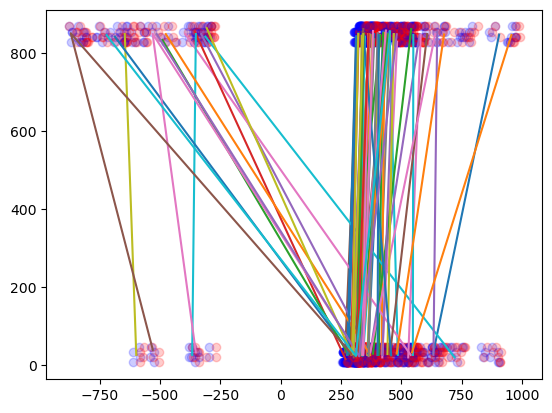

In [5]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

[(347, '[0, 1]'), (64, '[2, 3]'), (53, '[1]'), (25, '[0, 1, 2]'), (17, '[2]'), (12, '[1, 2]'), (12, '[0]'), (11, '[3]'), (5, '[0, 1, 3]'), (3, '[0, 1, 2, 3]'), (1, '[1, 2, 3]'), (1, '[0, 2]'), (1, '[0, 2, 3]')]
('[0, 1]', '[2, 3]', '[1]', '[0, 1, 2]', '[2]', '[1, 2]', '[0]', '[3]', '[0, 1, 3]', '[0, 1, 2, 3]', '[1, 2, 3]', '[0, 2]', '[0, 2, 3]') (347, 64, 53, 25, 17, 12, 12, 11, 5, 3, 1, 1, 1)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

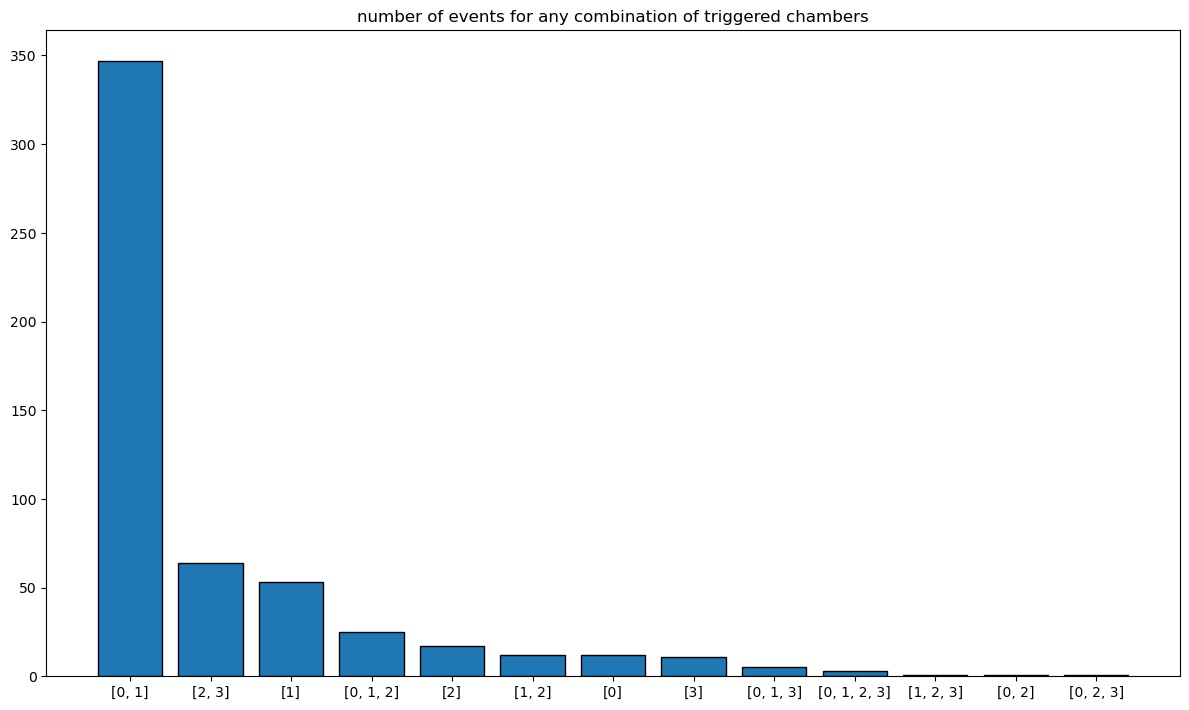

In [6]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

8.590778097982708
8



Text(0.5, 1.0, 'number of events vs number of hits for the calib_config chambers events')

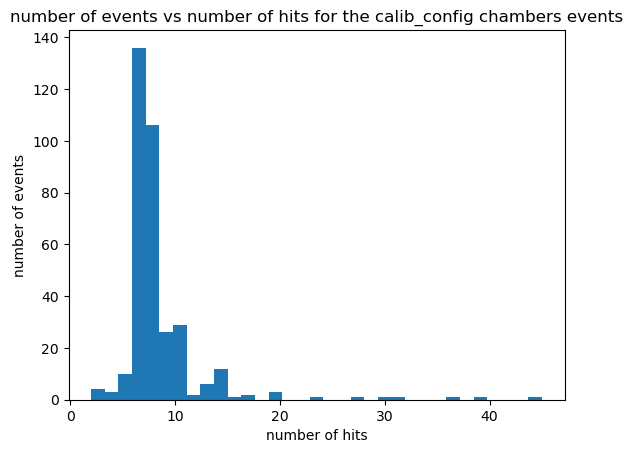

In [7]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(np.mean(n_hits_per_event))
print(np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])])
plt.hist(n_hits_per_event, bins=33)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title('number of events vs number of hits for the calib_config chambers events')

In [8]:
impeccable_events=list(filter(lambda key : sorted(np.unique(cal1[key]['chamber']))==calib_config and len(cal1[key])==8, cal1))
print(impeccable_events)
print(f"ratio between events in [2-3] config and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between events in [2-3] config and original dataset events {len(impeccable_events)/original_data_length}")

[3, 7, 14, 42, 50, 65, 66, 70, 97, 100, 105, 113, 116, 138, 139, 145, 172, 179, 186, 188, 201, 226, 232, 272, 281, 285, 286, 293, 299, 302, 317, 319, 325, 329, 339, 345, 349, 374, 381, 387, 393, 398, 401, 405, 419, 429, 444, 445, 447, 449, 473, 475, 481, 484, 486, 490, 492, 514, 530, 535, 552, 556, 580, 600, 633, 635, 636, 663, 683, 808, 827, 831, 854, 881, 942, 965, 990, 997, 1015, 1050, 1093, 1117, 1146, 1165, 1169, 1188, 1214, 1216, 1237, 1258, 1284, 1285, 1302, 1337, 1462, 1465, 1470, 1492, 1493, 1535, 1561, 1603, 1620, 1626, 1688, 1712]
ratio between events in [2-3] config and nonzerohit events 0.19202898550724637
 ratio between events in [2-3] config and original dataset events 0.07057256990679095


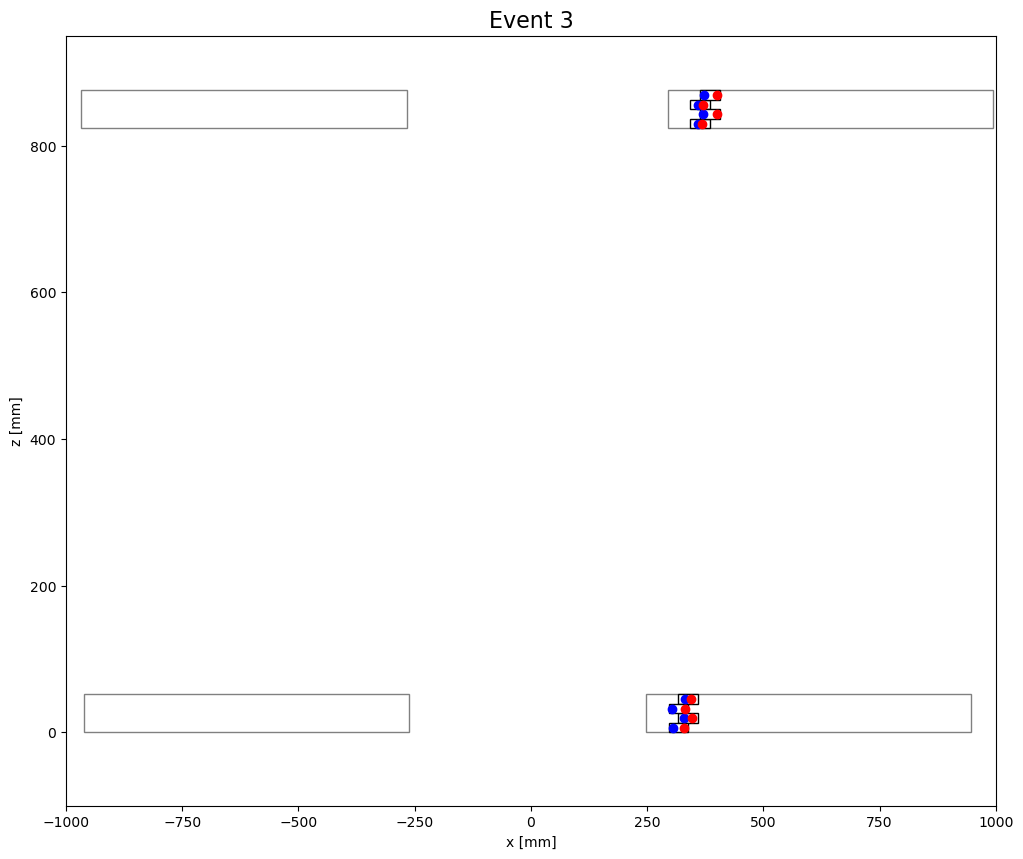

In [9]:
from matplotlib.patches import Rectangle

def event_plotter(event_number):
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    fig, ax=plt.subplots(figsize=(12,10))

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    ax.scatter(my_event['xlg'], my_event['zg'], color='blue')
    ax.scatter(my_event['xrg'], my_event['zg'], color='red')
    ax.set_xlim([-1000, 1000])
    ax.set_ylim([-100, 950])
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)
    plt.show()
    my_event

event_plotter(impeccable_events[0])

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory